In [1]:
import sys
#sys.path.append('/mnt/lustre01/pf/a/a270046/hierarchy/pyfesom_fork') # ut.py etc. (github)
sys.path.append('/mnt/lustre01/pf/a/a270046/hierarchy/pyfesom-master') # 

import matplotlib
#matplotlib.use('Agg') #-- use in batch mode
matplotlib.use('TkAgg')
from netCDF4 import Dataset, MFDataset
import pyfesom as pf
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pylab as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from matplotlib import cm
from colorbars import cmap_correlations256
import seawater as sw
import pandas as pd
from matplotlib import path

In [2]:
%matplotlib inline
%load_ext ipycache

/work/ab0995/a270046/miniconda2-install/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/work/ab0995/a270046/miniconda2-install/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


#### first, define some functions for loading and plotting of the data (re-used for all the grids!)

In [3]:
def load_andcompute_Hovmoeller_polygon(firstyear, lastyear, mesh, filetmp, polygon):
    "Load and compute Hovmoeller diagram for the period (firstyear---lastyear)."
    
    # load the files into one dataset
    files = [filetmp.format(d) for d in range(firstyear,lastyear+1,1)]
    fl = MFDataset(files)

    dimT=np.shape(fl.variables['temp'])[0]
    dimL=np.shape(mesh.zlevs)[0]
    hovmoeller_T=np.zeros((dimT, dimL))
    hovmoeller_S=np.zeros_like(hovmoeller_T)
    
    # find points in polygon STA ----------
    
    # the 2D grid points to be checked
    points=zip(mesh.x2, mesh.y2);

    # define polygon, e.g. North Atlantic Ocean
    # polygon = [(-65, 55), (-65, 66), (-15, 66), (20, 75), (30, 64), (60, 30), (20, 30), (20, 0), (-70, 0), (-70, 5), (-90, 15), (-110, 30)]
    natloce = path.Path(polygon)
    # the mask
    natloce_mask=natloce.contains_points(points)
    natloce_mask=natloce_mask*1.0 # bool -> real
    natloce_mask[natloce_mask==0]=np.nan
    
    # find points in polygon END ----------
        
    levelidx=-1
    for depth in mesh.zlevs:
        
        levelidx=levelidx+1
        print depth, levelidx
        
        # find indices for this level; "bring it to the surface"
        ind_depth, ind_noempty, ind_empty=pf.ind_for_depth(depth, mesh)
    
        print 'Computing weighted mean ...'
        mularea=mesh.lump2[ind_noempty]
        print np.nansum(mularea), np.shape(mularea), np.sum(np.isnan(mularea))
        mularea=mesh.lump2[ind_noempty]*natloce_mask[ind_noempty]
        print np.nansum(mularea), np.shape(mularea), np.sum(np.isnan(mularea))
        hovmoeller_T[:,levelidx] = np.nansum( np.copy(fl.variables['temp'][:,ind_depth[ind_noempty]])*mularea,axis=1 )/np.nansum(mularea) # (time) x (1 level)
        hovmoeller_S[:,levelidx] = np.nansum( np.copy(fl.variables['salt'][:,ind_depth[ind_noempty]])*mularea,axis=1 )/np.nansum(mularea) # (time) x (1 level)
        #hovmoeller_T[:,levelidx] = fl.variables['temp'][:,ind_depth[ind_noempty]].mean(axis=1) # (time) x (1 level)
        #hovmoeller_S[:,levelidx] = fl.variables['salt'][:,ind_depth[ind_noempty]].mean(axis=1) # (time) x (1 level)
        print 'Done.'
    
    return mesh.zlevs, hovmoeller_T, hovmoeller_S
    

In [4]:
def load_andcompute_Hovmoeller(firstyear, lastyear, mesh, filetmp ):
    "Load and compute Hovmoeller diagram for the period (firstyear---lastyear)."
    
    # load the files into one dataset
    files = [filetmp.format(d) for d in range(firstyear,lastyear+1,1)]
    fl = MFDataset(files)

    dimT=np.shape(fl.variables['temp'])[0]
    dimL=np.shape(mesh.zlevs)[0]
    hovmoeller_T=np.zeros((dimT, dimL))
    hovmoeller_S=np.zeros_like(hovmoeller_T)
        
    levelidx=-1
    for depth in mesh.zlevs:
        
        levelidx=levelidx+1
        print depth, levelidx
        
        # find indices for this level; "bring it to the surface"
        ind_depth, ind_noempty, ind_empty=pf.ind_for_depth(depth, mesh)
    
        print 'Computing weighted mean ...'
        mularea=mesh.lump2[ind_noempty]
        hovmoeller_T[:,levelidx] = (fl.variables['temp'][:,ind_depth[ind_noempty]]*mularea).sum(axis=1)/np.sum(mularea) # (time) x (1 level)
        hovmoeller_S[:,levelidx] = (fl.variables['salt'][:,ind_depth[ind_noempty]]*mularea).sum(axis=1)/np.sum(mularea) # (time) x (1 level)
        #hovmoeller_T[:,levelidx] = fl.variables['temp'][:,ind_depth[ind_noempty]].mean(axis=1) # (time) x (1 level)
        #hovmoeller_S[:,levelidx] = fl.variables['salt'][:,ind_depth[ind_noempty]].mean(axis=1) # (time) x (1 level)
        print 'Done.'
    
    return mesh.zlevs, hovmoeller_T, hovmoeller_S
    

#### profiles

In [5]:
from collections import OrderedDict
profiles=OrderedDict()
profiles['temperature']=OrderedDict()
profiles['salinity']=OrderedDict()

profiles['temperature']['REF']=OrderedDict()
profiles['salinity']['REF']=OrderedDict()

profiles['temperature']['LR']=OrderedDict()
profiles['salinity']['LR']=OrderedDict()

profiles['temperature']['MR0']=OrderedDict()
profiles['salinity']['MR0']=OrderedDict()

profiles['temperature']['MR']=OrderedDict()
profiles['salinity']['MR']=OrderedDict()

profiles['temperature']['HR']=OrderedDict()
profiles['salinity']['HR']=OrderedDict()

### CORE

In [6]:
# config
meshname4plots ='LR'
meshpath  ='/work/bm0944/input/CORE2_final/' # COREII at DKRZ

# original data
#filetmp = '/work/ab0995/a270046/hierarchy-grids/cpl_output/fesom.{}.oce.mean.nc' # COREII data at DKRZ
# annual means
filetmp = '/work/ab0995/a270046/hierarchy-grids/cpl_output/cdo-postprocessing/fesom.{}.oce.annualmean.nc' # annual COREII data at DKRZ

# load mesh
mesh = pf.load_mesh(meshpath, get3d=True, usepickle=False, usejoblib=True)

The usejoblib == True)
The joblib file for python 2 exists.
The mesh will be loaded from /work/bm0944/input/CORE2_final/joblib_mesh


#### define the polygon; check which grid points are inside

In [7]:
# the 2D grid points to be checked
points=zip(mesh.x2, mesh.y2);

# define polygon (Tido's definition for the profiles)
polygon = [(-65, 55), (-65, 66), (-15, 66), (20, 75), (30, 64), (60, 30), (20, 30), (20, 0), (-70, 0), (-70, 5), (-90, 15), (-110, 30)]
natloce = path.Path(polygon)

natloce_mask=natloce.contains_points(points)

In [8]:
natloce_mask.shape, mesh.x2.shape

((126859,), (126859,))

In [9]:
# load climatology
climpath='/mnt/lustre01/work/bm0944/a270046/DATA/climatology/'
clim = pf.climatology(climpath, climname='phc') # climname='phc'|'woa05'
    
# map fesom data to PHC climatology grid
xx,yy = np.meshgrid(clim.x, clim.y)

distances, inds = pf.create_indexes_and_distances(mesh, xx, yy, k=10, n_jobs=2)
    
# remap mean
zz_mask = pf.fesom2regular(natloce_mask, mesh, xx, yy, distances=distances,\
                                inds=inds, how='idist', k=10,\
                                radius_of_influence=200000)
    
# set land to NaN
zz_mask[np.isnan(clim.T[0,:,:])]=np.nan

/mnt/lustre01/pf/a/a270046/hierarchy/pyfesom-master/pyfesom/climatology.py:83: RuntimeWarning: invalid value encountered in greater
  self.T = np.copy(ncfile.variables['temp'][:,:,:])
/mnt/lustre01/pf/a/a270046/hierarchy/pyfesom-master/pyfesom/climatology.py:92: RuntimeWarning: invalid value encountered in greater
  self.S=np.copy(ncfile.variables['salt'][:,:,:])
/mnt/lustre01/pf/a/a270046/hierarchy/pyfesom-master/pyfesom/climatology.py:100: RuntimeWarning: Mean of empty slice
  self.Tyz=nanmean(self.T, 2)
/mnt/lustre01/pf/a/a270046/hierarchy/pyfesom-master/pyfesom/climatology.py:101: RuntimeWarning: Mean of empty slice
  self.Syz=nanmean(self.S, 2)


#### Is the mask correct?

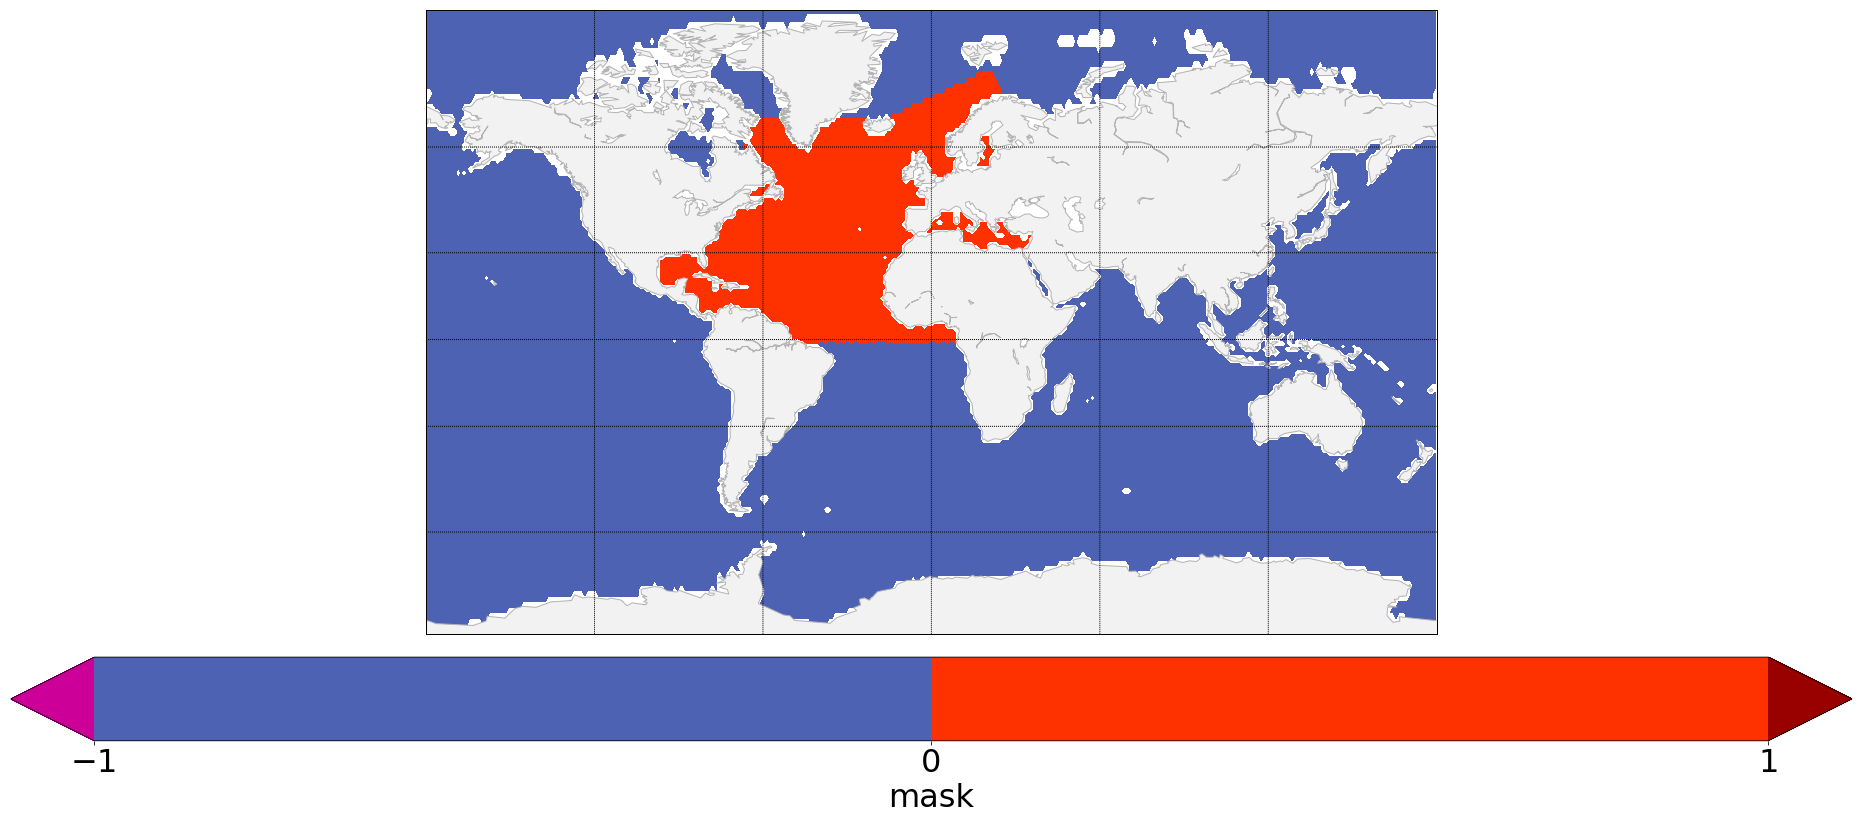

In [10]:
# ------------------------------------------------------- #
# plot FESOM mask
m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=85,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')
x,y = m(xx,yy) # coordinates for target grid

    
fig=plt.figure(figsize=(33,14))

plt.subplot(111)
m.drawmapboundary(fill_color='white')
m.drawcoastlines(linewidth=1.0, linestyle='solid', color='0.7', antialiased=1)
m.fillcontinents(color='0.95')

levels = np.arange(-1., 2.0, 1.0)
MASK=plt.contourf(x, y, zz_mask, levels = levels, \
                cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic

m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0])
m.drawmeridians(np.arange(-120,120+60,60),labels=[0,0,0,0])
cbar=plt.colorbar(orientation = 'horizontal', pad=0.03)
cbar.set_label('mask', fontsize=32)
cbar.ax.tick_params(labelsize=32)

In [11]:
%%cache core_hovmoeller.pkl levels hovmoeller_T hovmoeller_S

# all years
firstyear=2008 #2008
lastyear=2107

# load data and compute density for above period
levels, hovmoeller_T, hovmoeller_S = load_andcompute_Hovmoeller_polygon(firstyear=firstyear, \
                                                                lastyear=lastyear, \
                                                                mesh=mesh, \
                                                                filetmp=filetmp, \
                                                                polygon=polygon)

[Skipped the cell's code and loaded variables hovmoeller_S, hovmoeller_T, levels from file '/mnt/lustre01/pf/a/a270046/hierarchy/myvisualization/core_hovmoeller.pkl'.]
-0.0 0
Computing weighted mean ...
3.6474921982e+14 (126859,) 0
4.69942663395e+13 (126859,) 104629
Done.
10.0 1
Computing weighted mean ...
3.6474921982e+14 (126859,) 0
4.69942663395e+13 (126859,) 104629
Done.
20.0 2
Computing weighted mean ...
3.6474921982e+14 (126859,) 0
4.69942663395e+13 (126859,) 104629
Done.
30.0 3
Computing weighted mean ...
3.63353024511e+14 (123369,) 0
4.67792255598e+13 (123369,) 101691
Done.
40.0 4
Computing weighted mean ...
3.62312165248e+14 (121151,) 0
4.65169400708e+13 (121151,) 99966
Done.
50.0 5
Computing weighted mean ...
3.61256498168e+14 (119130,) 0
4.62709490719e+13 (119130,) 98357
Done.
60.0 6
Computing weighted mean ...
3.56694590976e+14 (115471,) 0
4.57742081586e+13 (115471,) 95192
Done.
70.0 7
Computing weighted mean ...
3.54549442163e+14 (113394,) 0
4.53947059246e+13 (113394,) 935

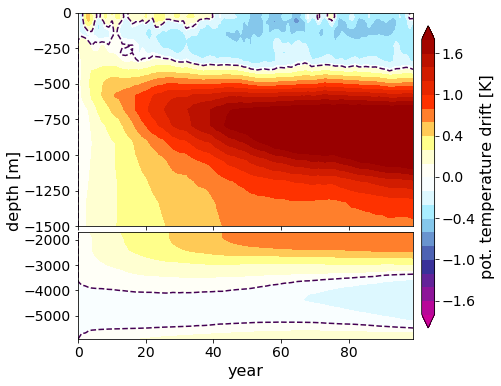

In [12]:
# plot Hovmoeller diagram
fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False, figsize=(6,6), gridspec_kw = {'height_ratios':[2, 1]})
emphasize=28 #25

#conlevels = np.arange(-2., 2.+0.2, 0.2) # -2 to 2 degrees
conlevels = np.array([-1.8,-1.6,-1.4,-1.2,-1.0,-0.8,-0.6,-0.4,-0.2, -0.05,0.,0.05, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8])
TT,LL=np.meshgrid(np.arange(0,np.shape(hovmoeller_T)[0]), -levels)
HOV=(hovmoeller_T-hovmoeller_T[0,:]).T
#HOV=(hovmoeller_T-hovmoeller_T[0:10,:].mean(axis=0)).T # initial decade

# plot diagram
CS0 = ax1.contourf(TT[0:emphasize,:], LL[0:emphasize,:], HOV[0:emphasize,:], levels = conlevels, cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
# add contour of neutral change
ax1.contour(TT[0:emphasize,:], LL[0:emphasize,:], HOV[0:emphasize,:], levels = [0], color='k', linestyles='dashed'); # cm.seismic
#ax1.set_xlim([-1, 100])

# plot lower diagram
CS1 = ax2.contourf(TT[emphasize: ,:], LL[emphasize:, :], HOV[emphasize:, :], levels = conlevels, cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
# add contour of neutral change
ax2.contour(TT[emphasize: ,:], LL[emphasize:, :], HOV[emphasize:, :], levels = [0], color='k', linestyles='dashed');
#ax2.set_xlim([-1, 100])
fig.subplots_adjust(hspace=0.035)

# change font sizes
plt.xlabel('year', fontsize=16)
plt.text(-21,1000, 'depth [m]', fontsize=16, rotation=90) # plt.ylabel('depth [m]', fontsize=16)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
ax1.tick_params(axis='y', labelsize=14)

# add colorbar

# Make an axis for the colorbar on the right side
cax = fig.add_axes([0.92, 0.15, 0.03, 0.7]) #[*left*, *bottom*, *width*, *height*]
cbar=plt.colorbar(CS0, cax=cax)
cbar.set_label('pot. temperature drift [K]', fontsize=16)
cbar.ax.tick_params(labelsize=14) 

#plt.tight_layout()
#plt.close('all')

In [13]:
HOV[:,70:100].mean(axis=1)

array([-0.2206279 , -0.22089615, -0.21841074, -0.20751331, -0.23904192,
       -0.28914868, -0.333284  , -0.36050296, -0.37715994, -0.39191084,
       -0.39805385, -0.41905253, -0.41573957, -0.38964264, -0.32870812,
       -0.27855069, -0.25769485, -0.16989433,  0.11955858,  0.64539079,
        1.33104038,  1.99593756,  2.48519426,  2.41188845,  1.82910524,
        1.20048392,  0.83714868,  0.72990174,  0.75621599,  0.77854796,
        0.729129  ,  0.62256248,  0.44128451,  0.23949762,  0.08476548,
        0.011099  , -0.03574916, -0.07068239, -0.09305413, -0.09443817,
       -0.07246834, -0.05225388, -0.02833232,  0.00250635,  0.05263233,
        0.12022524])

In [14]:
profiles['temperature']['LR']['initial']=HOV[:,0]
profiles['temperature']['LR']['last']=HOV[:,70:100].mean(axis=1)

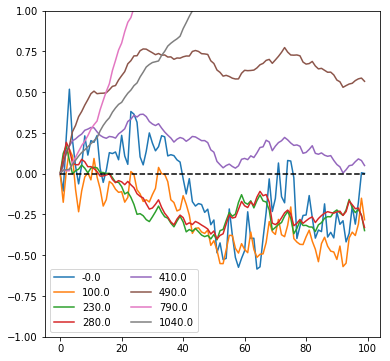

In [15]:
# time series
fig2=plt.figure(figsize=(6,6))

plt.plot(HOV[0,:], label=str(levels[0])) # 0
plt.plot(HOV[10,:], label=str(levels[10])) # 100


plt.plot(HOV[15,:], label=str(levels[15])) # 200

plt.plot(HOV[16,:], label=str(levels[16])) # 300

plt.plot(HOV[18,:], label=str(levels[18])) # 400

plt.plot(HOV[19,:], label=str(levels[19])) # 500

plt.plot(HOV[22,:], label=str(levels[22]))

plt.plot(HOV[24,:], label=str(levels[24]))

plt.ylim(-1.,1.)

plt.plot(np.zeros_like(HOV.mean(axis=0)), linestyle='dashed', color='k')
plt.legend(ncol=2)

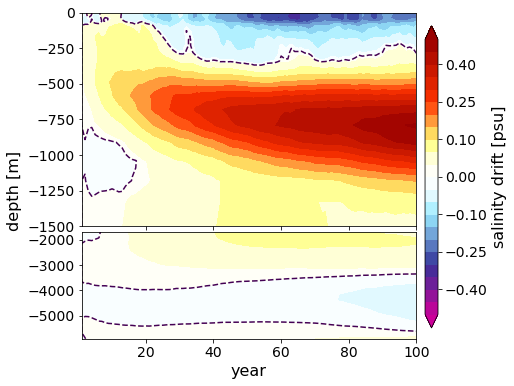

In [16]:
# plot Hovmoeller S diagram
fig3, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False, figsize=(6,6), gridspec_kw = {'height_ratios':[2, 1]})
emphasize=28 #25

#conlevels = np.arange(-0.5, 0.5+0.05, 0.05) # 
conlevels = np.array([-0.5,-0.45,-0.4,-0.35,-0.3,-0.25,-0.2,-0.15,-0.1,-0.05, -0.01,0.,0.01, 0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5])
TT,LL=np.meshgrid(np.arange(0,np.shape(hovmoeller_S)[0]), -levels)
HOV=(hovmoeller_S-hovmoeller_S[0,:]).T
#HOV=(hovmoeller_T-hovmoeller_T[0:10,:].mean(axis=0)).T # initial decade

# plot diagram
CS0 = ax1.contourf(1+TT[0:emphasize,:], LL[0:emphasize,:], HOV[0:emphasize,:], levels = conlevels, cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
# add contour of neutral change
ax1.contour(1+TT[0:emphasize,:], LL[0:emphasize,:], HOV[0:emphasize,:], levels = [0], color='k', linestyles='dashed'); # cm.seismic

# plot lower diagram
CS1 = ax2.contourf(1+TT[emphasize: ,:], LL[emphasize:, :], HOV[emphasize:, :], levels = conlevels, cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
# add contour of neutral change
ax2.contour(1+TT[emphasize: ,:], LL[emphasize:, :], HOV[emphasize:, :], levels = [0], color='k', linestyles='dashed');
fig3.subplots_adjust(hspace=0.035)

# change font sizes
plt.xlabel('year', fontsize=16)
plt.text(-21,1000, 'depth [m]', fontsize=16, rotation=90) # plt.ylabel('depth [m]', fontsize=16)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
ax1.tick_params(axis='y', labelsize=14)

# add colorbar

# Make an axis for the colorbar on the right side
cax = fig3.add_axes([0.92, 0.15, 0.03, 0.7]) #[*left*, *bottom*, *width*, *height*]
cbar=plt.colorbar(CS0, cax=cax)
cbar.set_label('salinity drift [psu]', fontsize=16)
cbar.ax.tick_params(labelsize=14) 

#plt.tight_layout()
#plt.close('all')

In [17]:
profiles['salinity']['LR']['initial']=HOV[:,0]
profiles['salinity']['LR']['last']=HOV[:,70:100].mean(axis=1)

In [18]:
mkdir -p /pf/a/a270046/hierarchy/figuresJuly2018/

In [19]:
saveFIG=True
if saveFIG==True:
   pp = PdfPages('/pf/a/a270046/hierarchy/figuresJuly2018/hovmoeller_'+meshname4plots+'.pdf')
   pp.savefig(fig,bbox_inches = 'tight')
   pp.close()

   pp = PdfPages('/pf/a/a270046/hierarchy/figuresJuly2018/hovmoeller_series_'+meshname4plots+'.pdf')
   pp.savefig(fig2,bbox_inches = 'tight')
   pp.close()
    
   pp = PdfPages('/pf/a/a270046/hierarchy/figuresJuly2018/hovmoeller_S_'+meshname4plots+'.pdf')
   pp.savefig(fig3,bbox_inches = 'tight')
   pp.close() 

## load REF

In [20]:
# config
meshname4plots ='REF'
meshpath  ='/work/bm0944/input/mesh_ref87k/' # REF at DKRZ

# original data
#filetmp = '/work/ab0995/a270046/hierarchy-grids/cpl_output_ref87k/fesom.{}.oce.mean.nc' # REF at DKRZ
# annual means
filetmp = '/work/ab0995/a270046/hierarchy-grids/cpl_output_ref87k/cdo-postprocessing/fesom.{}.oce.annualmean.nc'


# load mesh
mesh = pf.load_mesh(meshpath, get3d=True, usepickle=False, usejoblib=True)

The usejoblib == True)
The joblib file for python 2 exists.
The mesh will be loaded from /work/bm0944/input/mesh_ref87k/joblib_mesh


In [21]:
%%cache ref_hovmoeller.pkl levels hovmoeller_T hovmoeller_S

# all years
firstyear=1851
lastyear=1950 

# load data and compute density for above period
levels, hovmoeller_T, hovmoeller_S = load_andcompute_Hovmoeller_polygon(firstyear=firstyear, \
                                                                lastyear=lastyear, \
                                                                mesh=mesh, \
                                                                filetmp=filetmp, \
                                                                polygon=polygon)

[Skipped the cell's code and loaded variables hovmoeller_S, hovmoeller_T, levels from file '/mnt/lustre01/pf/a/a270046/hierarchy/myvisualization/ref_hovmoeller.pkl'.]
-0.0 0
Computing weighted mean ...
3.56850657362e+14 (86803,) 0
4.6411944534e+13 (86803,) 73206
Done.
10.0 1
Computing weighted mean ...
3.56850657362e+14 (86803,) 0
4.6411944534e+13 (86803,) 73206
Done.
20.0 2
Computing weighted mean ...
3.56850657362e+14 (86803,) 0
4.6411944534e+13 (86803,) 73206
Done.
30.0 3
Computing weighted mean ...
3.56850657362e+14 (86803,) 0
4.6411944534e+13 (86803,) 73206
Done.
40.0 4
Computing weighted mean ...
3.5318579489e+14 (84299,) 0
4.57258985785e+13 (84299,) 71292
Done.
50.0 5
Computing weighted mean ...
3.51622454736e+14 (83523,) 0
4.54602633396e+13 (83523,) 70682
Done.
60.0 6
Computing weighted mean ...
3.50363325265e+14 (82869,) 0
4.52566258988e+13 (82869,) 70176
Done.
70.0 7
Computing weighted mean ...
3.49295419438e+14 (82284,) 0
4.50295398099e+13 (82284,) 69746
Done.
80.0 8
Computi

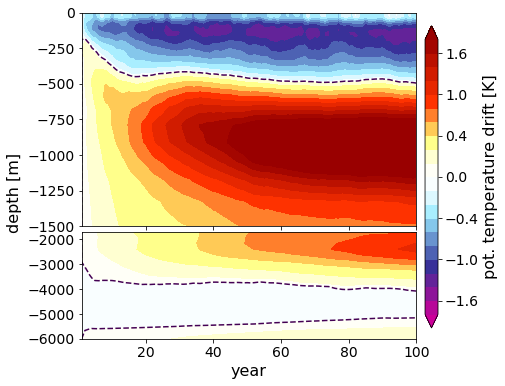

In [22]:
# plot Hovmoeller diagram
fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False, figsize=(6,6), gridspec_kw = {'height_ratios':[2, 1]})
emphasize=28 #25

#conlevels = np.arange(-2., 2.+0.2, 0.2) # -2 to 2 degrees
conlevels = np.array([-1.8,-1.6,-1.4,-1.2,-1.0,-0.8,-0.6,-0.4,-0.2, -0.05,0.,0.05, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8])
TT,LL=np.meshgrid(np.arange(0,np.shape(hovmoeller_T)[0]), -levels)
HOV=(hovmoeller_T-hovmoeller_T[0,:]).T
#HOV=(hovmoeller_T-hovmoeller_T[0:10,:].mean(axis=0)).T # initial decade

# plot diagram
CS0 = ax1.contourf(1+TT[0:emphasize,:], LL[0:emphasize,:], HOV[0:emphasize,:], levels = conlevels, cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
# add contour of neutral change
ax1.contour(1+TT[0:emphasize,:], LL[0:emphasize,:], HOV[0:emphasize,:], levels = [0], color='k', linestyles='dashed'); # cm.seismic

# plot lower diagram
CS1 = ax2.contourf(1+TT[emphasize: ,:], LL[emphasize:, :], HOV[emphasize:, :], levels = conlevels, cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
# add contour of neutral change
ax2.contour(1+TT[emphasize: ,:], LL[emphasize:, :], HOV[emphasize:, :], levels = [0], color='k', linestyles='dashed');
fig.subplots_adjust(hspace=0.035)

# change font sizes
plt.xlabel('year', fontsize=16)
plt.text(-21,1000, 'depth [m]', fontsize=16, rotation=90) # plt.ylabel('depth [m]', fontsize=16)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
ax1.tick_params(axis='y', labelsize=14)

# add colorbar

# Make an axis for the colorbar on the right side
cax = fig.add_axes([0.92, 0.15, 0.03, 0.7]) #[*left*, *bottom*, *width*, *height*]
cbar=plt.colorbar(CS0, cax=cax)
cbar.set_label('pot. temperature drift [K]', fontsize=16)
cbar.ax.tick_params(labelsize=14) 

#plt.tight_layout()
#plt.close('all')

In [23]:
profiles['temperature']['REF']['initial']=HOV[:,0]
profiles['temperature']['REF']['last']=HOV[:,70:100].mean(axis=1)

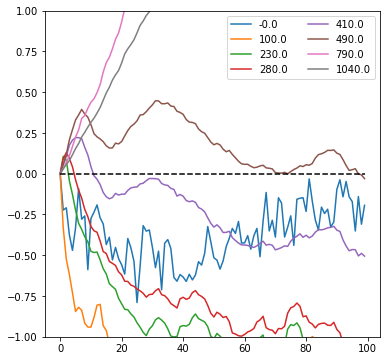

In [24]:
# time series
fig2=plt.figure(figsize=(6,6))

plt.plot(HOV[0,:], label=str(levels[0])) # 0
plt.plot(HOV[10,:], label=str(levels[10])) # 100


plt.plot(HOV[15,:], label=str(levels[15])) # 200

plt.plot(HOV[16,:], label=str(levels[16])) # 300

plt.plot(HOV[18,:], label=str(levels[18])) # 400

plt.plot(HOV[19,:], label=str(levels[19])) # 500

plt.plot(HOV[22,:], label=str(levels[22]))

plt.plot(HOV[24,:], label=str(levels[24]))

plt.ylim(-1.,1.)

plt.plot(np.zeros_like(HOV.mean(axis=0)), linestyle='dashed', color='k')
plt.legend(ncol=2)

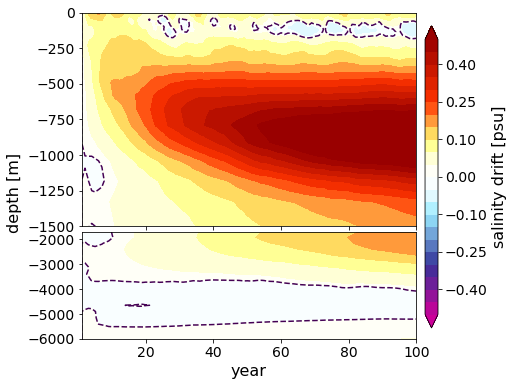

In [25]:
# plot Hovmoeller S diagram
fig3, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False, figsize=(6,6), gridspec_kw = {'height_ratios':[2, 1]})
emphasize=28 #25

#conlevels = np.arange(-0.5, 0.5+0.05, 0.05) # 
conlevels = np.array([-0.5,-0.45,-0.4,-0.35,-0.3,-0.25,-0.2,-0.15,-0.1,-0.05, -0.01,0.,0.01, 0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5])
TT,LL=np.meshgrid(np.arange(0,np.shape(hovmoeller_S)[0]), -levels)
HOV=(hovmoeller_S-hovmoeller_S[0,:]).T
#HOV=(hovmoeller_T-hovmoeller_T[0:10,:].mean(axis=0)).T # initial decade

# plot diagram
CS0 = ax1.contourf(1+TT[0:emphasize,:], LL[0:emphasize,:], HOV[0:emphasize,:], levels = conlevels, cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
# add contour of neutral change
ax1.contour(1+TT[0:emphasize,:], LL[0:emphasize,:], HOV[0:emphasize,:], levels = [0], color='k', linestyles='dashed'); # cm.seismic

# plot lower diagram
CS1 = ax2.contourf(1+TT[emphasize: ,:], LL[emphasize:, :], HOV[emphasize:, :], levels = conlevels, cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
# add contour of neutral change
ax2.contour(1+TT[emphasize: ,:], LL[emphasize:, :], HOV[emphasize:, :], levels = [0], color='k', linestyles='dashed');
fig3.subplots_adjust(hspace=0.035)

# change font sizes
plt.xlabel('year', fontsize=16)
plt.text(-21,1000, 'depth [m]', fontsize=16, rotation=90) # plt.ylabel('depth [m]', fontsize=16)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
ax1.tick_params(axis='y', labelsize=14)

# add colorbar

# Make an axis for the colorbar on the right side
cax = fig3.add_axes([0.92, 0.15, 0.03, 0.7]) #[*left*, *bottom*, *width*, *height*]
cbar=plt.colorbar(CS0, cax=cax)
cbar.set_label('salinity drift [psu]', fontsize=16)
cbar.ax.tick_params(labelsize=14) 

#plt.tight_layout()
#plt.close('all')

In [26]:
profiles['salinity']['REF']['initial']=HOV[:,0]
profiles['salinity']['REF']['last']=HOV[:,70:100].mean(axis=1)

In [27]:
saveFIG=True
if saveFIG==True:
   pp = PdfPages('/pf/a/a270046/hierarchy/figuresJuly2018/hovmoeller_'+meshname4plots+'.pdf')
   pp.savefig(fig,bbox_inches = 'tight')
   pp.close()

   pp = PdfPages('/pf/a/a270046/hierarchy/figuresJuly2018/hovmoeller_series_'+meshname4plots+'.pdf')
   pp.savefig(fig2,bbox_inches = 'tight')
   pp.close()
    
   pp = PdfPages('/pf/a/a270046/hierarchy/figuresJuly2018/hovmoeller_S_'+meshname4plots+'.pdf')
   pp.savefig(fig3,bbox_inches = 'tight')
   pp.close() 

## AGUV mesh + data

In [28]:
# config
meshname4plots ='MR0'
meshpath  ='/work/bm0944/input/aguv/' # AGUV at DKRZ

# original data
#filetmp = '/work/ab0995/a270046/hierarchy-grids/cpl_output_T127aguv/fesom.{}.oce.mean.nc' # AGUV at DKRZ
# annual means
filetmp = '/work/ab0995/a270046/hierarchy-grids/cpl_output_T127aguv/cdo-postprocessing/fesom.{}.oce.annualmean.nc'

# load mesh
mesh = pf.load_mesh(meshpath, abg=[0, 0, 0], get3d=True, usepickle=False, usejoblib=True)

The usejoblib == True)
The joblib file for python 2 exists.
The mesh will be loaded from /work/bm0944/input/aguv/joblib_mesh


In [29]:
%%cache aguv_hovmoeller.pkl levels hovmoeller_T hovmoeller_S

# all years
firstyear=2008
lastyear=2107

# load data and compute density for above period
levels, hovmoeller_T, hovmoeller_S = load_andcompute_Hovmoeller_polygon(firstyear=firstyear, \
                                                                lastyear=lastyear, \
                                                                mesh=mesh, \
                                                                filetmp=filetmp, \
                                                                polygon=polygon)

[Skipped the cell's code and loaded variables hovmoeller_S, hovmoeller_T, levels from file '/mnt/lustre01/pf/a/a270046/hierarchy/myvisualization/aguv_hovmoeller.pkl'.]
-0.0 0
Computing weighted mean ...
3.62640067482e+14 (810471,) 0
4.6191179555e+13 (810471,) 697964
Done.
10.0 1
Computing weighted mean ...
3.62640067482e+14 (810471,) 0
4.6191179555e+13 (810471,) 697964
Done.
20.0 2
Computing weighted mean ...
3.62640067482e+14 (810471,) 0
4.6191179555e+13 (810471,) 697964
Done.
30.0 3
Computing weighted mean ...
3.62640067482e+14 (810471,) 0
4.6191179555e+13 (810471,) 697964
Done.
40.0 4
Computing weighted mean ...
3.56390262494e+14 (766567,) 0
4.46560863585e+13 (766567,) 666932
Done.
50.0 5
Computing weighted mean ...
3.53625138787e+14 (751295,) 0
4.40709047673e+13 (751295,) 655238
Done.
60.0 6
Computing weighted mean ...
3.51336090091e+14 (740132,) 0
4.36650647822e+13 (740132,) 646096
Done.
70.0 7
Computing weighted mean ...
3.49372825041e+14 (731420,) 0
4.33119899769e+13 (731420,) 6

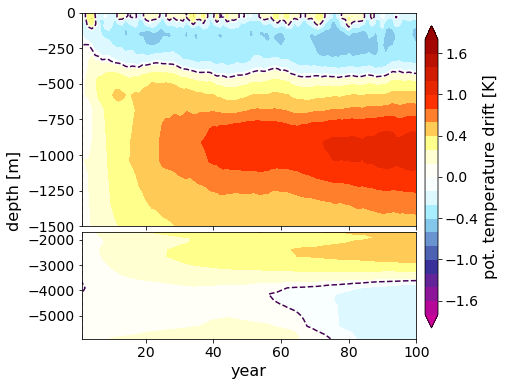

In [30]:
# plot Hovmoeller diagram
fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False, figsize=(6,6), gridspec_kw = {'height_ratios':[2, 1]})
emphasize=28 #25

#conlevels = np.arange(-2., 2.+0.2, 0.2) # -2 to 2 degrees
conlevels = np.array([-1.8,-1.6,-1.4,-1.2,-1.0,-0.8,-0.6,-0.4,-0.2, -0.05,0.,0.05, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8])
TT,LL=np.meshgrid(np.arange(0,np.shape(hovmoeller_T)[0]), -levels)
HOV=(hovmoeller_T-hovmoeller_T[0,:]).T
#HOV=(hovmoeller_T-hovmoeller_T[0:10,:].mean(axis=0)).T # initial decade

# plot diagram
CS0 = ax1.contourf(1+TT[0:emphasize,:], LL[0:emphasize,:], HOV[0:emphasize,:], levels = conlevels, cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
# add contour of neutral change
ax1.contour(1+TT[0:emphasize,:], LL[0:emphasize,:], HOV[0:emphasize,:], levels = [0], color='k', linestyles='dashed'); # cm.seismic

# plot lower diagram
CS1 = ax2.contourf(1+TT[emphasize: ,:], LL[emphasize:, :], HOV[emphasize:, :], levels = conlevels, cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
# add contour of neutral change
ax2.contour(1+TT[emphasize: ,:], LL[emphasize:, :], HOV[emphasize:, :], levels = [0], color='k', linestyles='dashed');
fig.subplots_adjust(hspace=0.035)

# change font sizes
plt.xlabel('year', fontsize=16)
plt.text(-21,1000, 'depth [m]', fontsize=16, rotation=90) # plt.ylabel('depth [m]', fontsize=16)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
ax1.tick_params(axis='y', labelsize=14)

# add colorbar

# Make an axis for the colorbar on the right side
cax = fig.add_axes([0.92, 0.15, 0.03, 0.7]) #[*left*, *bottom*, *width*, *height*]
cbar=plt.colorbar(CS0, cax=cax)
cbar.set_label('pot. temperature drift [K]', fontsize=16)
cbar.ax.tick_params(labelsize=14) 

#plt.tight_layout()
#plt.close('all')

In [31]:
profiles['temperature']['MR0']['initial']=HOV[:,0]
profiles['temperature']['MR0']['last']=HOV[:,70:100].mean(axis=1)

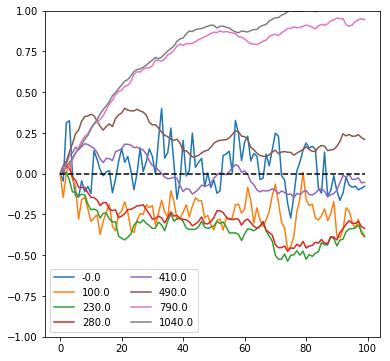

In [32]:
# time series
fig2=plt.figure(figsize=(6,6))

plt.plot(HOV[0,:], label=str(levels[0])) # 0
plt.plot(HOV[10,:], label=str(levels[10])) # 100


plt.plot(HOV[15,:], label=str(levels[15])) # 200

plt.plot(HOV[16,:], label=str(levels[16])) # 300

plt.plot(HOV[18,:], label=str(levels[18])) # 400

plt.plot(HOV[19,:], label=str(levels[19])) # 500

plt.plot(HOV[22,:], label=str(levels[22]))

plt.plot(HOV[24,:], label=str(levels[24]))

plt.ylim(-1.,1.)

plt.plot(np.zeros_like(HOV.mean(axis=0)), linestyle='dashed', color='k')
plt.legend(ncol=2)

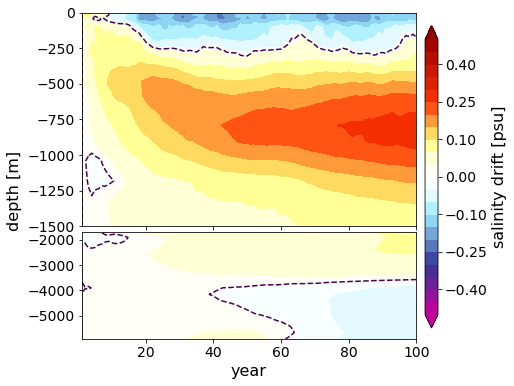

In [33]:
# plot Hovmoeller S diagram
fig3, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False, figsize=(6,6), gridspec_kw = {'height_ratios':[2, 1]})
emphasize=28 #25

#conlevels = np.arange(-0.5, 0.5+0.05, 0.05) # 
conlevels = np.array([-0.5,-0.45,-0.4,-0.35,-0.3,-0.25,-0.2,-0.15,-0.1,-0.05, -0.01,0.,0.01, 0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5])
TT,LL=np.meshgrid(np.arange(0,np.shape(hovmoeller_S)[0]), -levels)
HOV=(hovmoeller_S-hovmoeller_S[0,:]).T
#HOV=(hovmoeller_T-hovmoeller_T[0:10,:].mean(axis=0)).T # initial decade

# plot diagram
CS0 = ax1.contourf(1+TT[0:emphasize,:], LL[0:emphasize,:], HOV[0:emphasize,:], levels = conlevels, cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
# add contour of neutral change
ax1.contour(1+TT[0:emphasize,:], LL[0:emphasize,:], HOV[0:emphasize,:], levels = [0], color='k', linestyles='dashed'); # cm.seismic

# plot lower diagram
CS1 = ax2.contourf(1+TT[emphasize: ,:], LL[emphasize:, :], HOV[emphasize:, :], levels = conlevels, cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
# add contour of neutral change
ax2.contour(1+TT[emphasize: ,:], LL[emphasize:, :], HOV[emphasize:, :], levels = [0], color='k', linestyles='dashed');
fig3.subplots_adjust(hspace=0.035)

# change font sizes
plt.xlabel('year', fontsize=16)
plt.text(-21,1000, 'depth [m]', fontsize=16, rotation=90) # plt.ylabel('depth [m]', fontsize=16)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
ax1.tick_params(axis='y', labelsize=14)

# add colorbar

# Make an axis for the colorbar on the right side
cax = fig3.add_axes([0.92, 0.15, 0.03, 0.7]) #[*left*, *bottom*, *width*, *height*]
cbar=plt.colorbar(CS0, cax=cax)
cbar.set_label('salinity drift [psu]', fontsize=16)
cbar.ax.tick_params(labelsize=14) 

#plt.tight_layout()
#plt.close('all')

In [34]:
profiles['salinity']['MR0']['initial']=HOV[:,0]
profiles['salinity']['MR0']['last']=HOV[:,70:100].mean(axis=1)

In [35]:
saveFIG=True
if saveFIG==True:
   pp = PdfPages('/pf/a/a270046/hierarchy/figuresJuly2018/hovmoeller_'+meshname4plots+'.pdf')
   pp.savefig(fig,bbox_inches = 'tight')
   pp.close()

   pp = PdfPages('/pf/a/a270046/hierarchy/figuresJuly2018/hovmoeller_series_'+meshname4plots+'.pdf')
   pp.savefig(fig2,bbox_inches = 'tight')
   pp.close()
    
   pp = PdfPages('/pf/a/a270046/hierarchy/figuresJuly2018/hovmoeller_S_'+meshname4plots+'.pdf')
   pp.savefig(fig3,bbox_inches = 'tight')
   pp.close() 

## GLOB mesh + data

In [36]:
# config
meshname4plots ='MR'
meshpath  ='/work/ab0995/a270046/fesom-meshes/glob/' # GLOB at DKRZ

# original data
#filetmp = '/work/ab0995/a270046/hierarchy-grids/cpl_output_T127glob/fesom.{}.oce.mean.nc' # GLOB at DKRZ
# annual means
filetmp = '/work/ab0995/a270046/hierarchy-grids/cpl_output_T127glob/cdo-postprocessing/fesom.{}.oce.annualmean.nc'

# load mesh
mesh = pf.load_mesh(meshpath, abg=[0, 0, 0], get3d=True, usepickle=False, usejoblib=True)

The usejoblib == True)
The joblib file for python 2 exists.
The mesh will be loaded from /work/ab0995/a270046/fesom-meshes/glob/joblib_mesh


In [37]:
%%cache glob_hovmoeller.pkl levels hovmoeller_T hovmoeller_S

# all years
firstyear=2008
lastyear=2107

# load data and compute density for above period
levels, hovmoeller_T, hovmoeller_S = load_andcompute_Hovmoeller_polygon(firstyear=firstyear, \
                                                                lastyear=lastyear, \
                                                                mesh=mesh, \
                                                                filetmp=filetmp, \
                                                                polygon=polygon)

[Skipped the cell's code and loaded variables hovmoeller_S, hovmoeller_T, levels from file '/mnt/lustre01/pf/a/a270046/hierarchy/myvisualization/glob_hovmoeller.pkl'.]
-0.0 0
Computing weighted mean ...
3.62086057251e+14 (830305,) 0
4.67854610485e+13 (830305,) 636575
Done.
10.0 1
Computing weighted mean ...
3.62086057251e+14 (830305,) 0
4.67854610485e+13 (830305,) 636575
Done.
20.0 2
Computing weighted mean ...
3.62086057251e+14 (830305,) 0
4.67854610485e+13 (830305,) 636575
Done.
30.0 3
Computing weighted mean ...
3.62086057251e+14 (830305,) 0
4.67854610485e+13 (830305,) 636575
Done.
40.0 4
Computing weighted mean ...
3.52567086998e+14 (752658,) 0
4.45638533001e+13 (752658,) 580971
Done.
50.0 5
Computing weighted mean ...
3.50078123031e+14 (734901,) 0
4.40455412196e+13 (734901,) 567205
Done.
60.0 6
Computing weighted mean ...
3.47903641889e+14 (718617,) 0
4.36466279841e+13 (718617,) 553721
Done.
70.0 7
Computing weighted mean ...
3.46033355089e+14 (705106,) 0
4.33014096442e+13 (705106

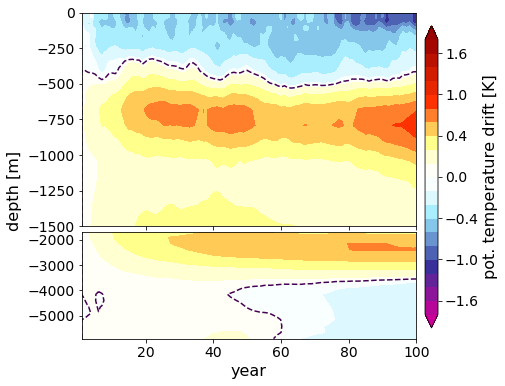

In [38]:
# plot Hovmoeller diagram
fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False, figsize=(6,6), gridspec_kw = {'height_ratios':[2, 1]})
emphasize=28 #25

#conlevels = np.arange(-2., 2.+0.2, 0.2) # -2 to 2 degrees
conlevels = np.array([-1.8,-1.6,-1.4,-1.2,-1.0,-0.8,-0.6,-0.4,-0.2, -0.05,0.,0.05, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8])
TT,LL=np.meshgrid(np.arange(0,np.shape(hovmoeller_T)[0]), -levels)
HOV=(hovmoeller_T-hovmoeller_T[0,:]).T
#HOV=(hovmoeller_T-hovmoeller_T[0:10,:].mean(axis=0)).T # initial decade

# plot diagram
CS0 = ax1.contourf(1+TT[0:emphasize,:], LL[0:emphasize,:], HOV[0:emphasize,:], levels = conlevels, cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
# add contour of neutral change
ax1.contour(1+TT[0:emphasize,:], LL[0:emphasize,:], HOV[0:emphasize,:], levels = [0], color='k', linestyles='dashed'); # cm.seismic

# plot lower diagram
CS1 = ax2.contourf(1+TT[emphasize: ,:], LL[emphasize:, :], HOV[emphasize:, :], levels = conlevels, cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
# add contour of neutral change
ax2.contour(1+TT[emphasize: ,:], LL[emphasize:, :], HOV[emphasize:, :], levels = [0], color='k', linestyles='dashed');
fig.subplots_adjust(hspace=0.035)

# change font sizes
plt.xlabel('year', fontsize=16)
plt.text(-21,1000, 'depth [m]', fontsize=16, rotation=90) # plt.ylabel('depth [m]', fontsize=16)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
ax1.tick_params(axis='y', labelsize=14)

# add colorbar

# Make an axis for the colorbar on the right side
cax = fig.add_axes([0.92, 0.15, 0.03, 0.7]) #[*left*, *bottom*, *width*, *height*]
cbar=plt.colorbar(CS0, cax=cax)
cbar.set_label('pot. temperature drift [K]', fontsize=16)
cbar.ax.tick_params(labelsize=14) 

#plt.tight_layout()
#plt.close('all')

In [39]:
profiles['temperature']['MR']['initial']=HOV[:,0]
profiles['temperature']['MR']['last']=HOV[:,70:100].mean(axis=1)

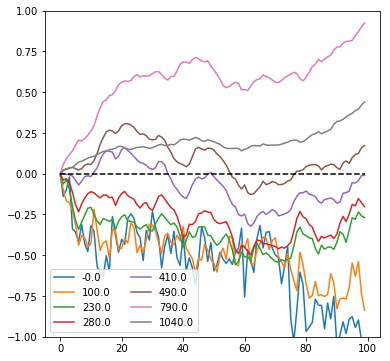

In [40]:
# time series
fig2=plt.figure(figsize=(6,6))

plt.plot(HOV[0,:], label=str(levels[0])) # 0
plt.plot(HOV[10,:], label=str(levels[10])) # 100


plt.plot(HOV[15,:], label=str(levels[15])) # 200

plt.plot(HOV[16,:], label=str(levels[16])) # 300

plt.plot(HOV[18,:], label=str(levels[18])) # 400

plt.plot(HOV[19,:], label=str(levels[19])) # 500

plt.plot(HOV[22,:], label=str(levels[22]))

plt.plot(HOV[24,:], label=str(levels[24]))

plt.ylim(-1.,1.)

plt.plot(np.zeros_like(HOV.mean(axis=0)), linestyle='dashed', color='k')
plt.legend(ncol=2)

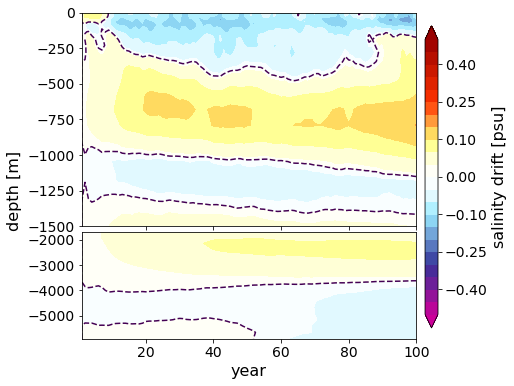

In [41]:
# plot Hovmoeller S diagram
fig3, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False, figsize=(6,6), gridspec_kw = {'height_ratios':[2, 1]})
emphasize=28 #25

#conlevels = np.arange(-0.5, 0.5+0.05, 0.05) # 
conlevels = np.array([-0.5,-0.45,-0.4,-0.35,-0.3,-0.25,-0.2,-0.15,-0.1,-0.05, -0.01,0.,0.01, 0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5])
TT,LL=np.meshgrid(np.arange(0,np.shape(hovmoeller_S)[0]), -levels)
HOV=(hovmoeller_S-hovmoeller_S[0,:]).T
#HOV=(hovmoeller_T-hovmoeller_T[0:10,:].mean(axis=0)).T # initial decade

# plot diagram
CS0 = ax1.contourf(1+TT[0:emphasize,:], LL[0:emphasize,:], HOV[0:emphasize,:], levels = conlevels, cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
# add contour of neutral change
ax1.contour(1+TT[0:emphasize,:], LL[0:emphasize,:], HOV[0:emphasize,:], levels = [0], color='k', linestyles='dashed'); # cm.seismic

# plot lower diagram
CS1 = ax2.contourf(1+TT[emphasize: ,:], LL[emphasize:, :], HOV[emphasize:, :], levels = conlevels, cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
# add contour of neutral change
ax2.contour(1+TT[emphasize: ,:], LL[emphasize:, :], HOV[emphasize:, :], levels = [0], color='k', linestyles='dashed');
fig3.subplots_adjust(hspace=0.035)

# change font sizes
plt.xlabel('year', fontsize=16)
plt.text(-21,1000, 'depth [m]', fontsize=16, rotation=90) # plt.ylabel('depth [m]', fontsize=16)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
ax1.tick_params(axis='y', labelsize=14)

# add colorbar

# Make an axis for the colorbar on the right side
cax = fig3.add_axes([0.92, 0.15, 0.03, 0.7]) #[*left*, *bottom*, *width*, *height*]
cbar=plt.colorbar(CS0, cax=cax)
cbar.set_label('salinity drift [psu]', fontsize=16)
cbar.ax.tick_params(labelsize=14) 

#plt.tight_layout()
#plt.close('all')

In [42]:
profiles['salinity']['MR']['initial']=HOV[:,0]
profiles['salinity']['MR']['last']=HOV[:,70:100].mean(axis=1)

In [43]:
saveFIG=True
if saveFIG==True:
   pp = PdfPages('/pf/a/a270046/hierarchy/figuresJuly2018/hovmoeller_'+meshname4plots+'.pdf')
   pp.savefig(fig,bbox_inches = 'tight')
   pp.close()

   pp = PdfPages('/pf/a/a270046/hierarchy/figuresJuly2018/hovmoeller_series_'+meshname4plots+'.pdf')
   pp.savefig(fig2,bbox_inches = 'tight')
   pp.close()
    
   pp = PdfPages('/pf/a/a270046/hierarchy/figuresJuly2018/hovmoeller_S_'+meshname4plots+'.pdf')
   pp.savefig(fig3,bbox_inches = 'tight')
   pp.close() 

## BOLD mesh + data

In [44]:
# config
meshname4plots ='HR'
meshpath  ='/work/ab0995/a270067/fesom/bold/mesh_Agulhas/' # BOLD at DKRZ

# original data
#filetmp = '/work/ab0995/a270046/hierarchy-grids/cpl_output_T127bold/fesom.{}.oce.mean.nc' # BOLD at DKRZ
# annual means
filetmp = '/work/ab0995/a270046/hierarchy-grids/cpl_output_T127bold/cdo-postprocessing/fesom.{}.oce.annualmean.nc'


# load mesh
mesh = pf.load_mesh(meshpath, abg=[0, 0, 0], get3d=True, usepickle=False, usejoblib=True)

The usejoblib == True)
The joblib file for python 2 exists.
The mesh will be loaded from /work/ab0995/a270067/fesom/bold/mesh_Agulhas/joblib_mesh


In [45]:
%%cache bold_hovmoeller.pkl levels hovmoeller_T hovmoeller_S

# all years
firstyear=2008
lastyear=2107

# load data and compute density for above period
levels, hovmoeller_T, hovmoeller_S = load_andcompute_Hovmoeller_polygon(firstyear=firstyear, \
                                                                lastyear=lastyear, \
                                                                mesh=mesh, \
                                                                filetmp=filetmp, \
                                                                polygon=polygon)

[Skipped the cell's code and loaded variables hovmoeller_S, hovmoeller_T, levels from file '/mnt/lustre01/pf/a/a270046/hierarchy/myvisualization/bold_hovmoeller.pkl'.]
-0.0 0
Computing weighted mean ...
3.6202808156e+14 (1306775,) 0
4.67793222298e+13 (1306775,) 1078876
Done.
10.0 1
Computing weighted mean ...
3.6202808156e+14 (1306775,) 0
4.67793222298e+13 (1306775,) 1078876
Done.
20.0 2
Computing weighted mean ...
3.6202808156e+14 (1306775,) 0
4.67793222298e+13 (1306775,) 1078876
Done.
30.0 3
Computing weighted mean ...
3.6202808156e+14 (1306775,) 0
4.67793222298e+13 (1306775,) 1078876
Done.
40.0 4
Computing weighted mean ...
3.58483086468e+14 (1272203,) 0
4.58629706157e+13 (1272203,) 1054416
Done.
50.0 5
Computing weighted mean ...
3.50262137568e+14 (1203379,) 0
4.40415375141e+13 (1203379,) 1001049
Done.
60.0 6
Computing weighted mean ...
3.48193903305e+14 (1187575,) 0
4.36716088686e+13 (1187575,) 987973
Done.
70.0 7
Computing weighted mean ...
3.46338431622e+14 (1173774,) 0
4.332137

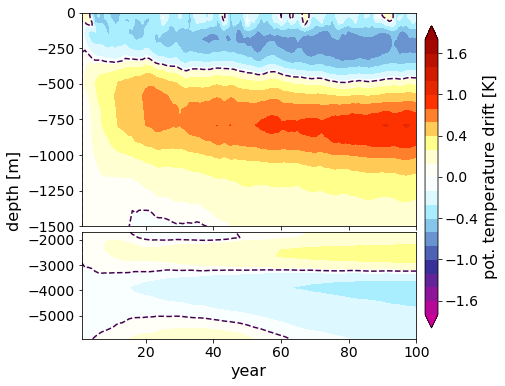

In [46]:
# plot Hovmoeller diagram
fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False, figsize=(6,6), gridspec_kw = {'height_ratios':[2, 1]})
emphasize=28 #25

#conlevels = np.arange(-2., 2.+0.2, 0.2) # -2 to 2 degrees
conlevels = np.array([-1.8,-1.6,-1.4,-1.2,-1.0,-0.8,-0.6,-0.4,-0.2, -0.05,0.,0.05, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8])
TT,LL=np.meshgrid(np.arange(0,np.shape(hovmoeller_T)[0]), -levels)
HOV=(hovmoeller_T-hovmoeller_T[0,:]).T
#HOV=(hovmoeller_T-hovmoeller_T[0:10,:].mean(axis=0)).T # initial decade

# plot diagram
CS0 = ax1.contourf(1+TT[0:emphasize,:], LL[0:emphasize,:], HOV[0:emphasize,:], levels = conlevels, cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
# add contour of neutral change
ax1.contour(1+TT[0:emphasize,:], LL[0:emphasize,:], HOV[0:emphasize,:], levels = [0], color='k', linestyles='dashed'); # cm.seismic

# plot lower diagram
CS1 = ax2.contourf(1+TT[emphasize: ,:], LL[emphasize:, :], HOV[emphasize:, :], levels = conlevels, cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
# add contour of neutral change
ax2.contour(1+TT[emphasize: ,:], LL[emphasize:, :], HOV[emphasize:, :], levels = [0], color='k', linestyles='dashed');
fig.subplots_adjust(hspace=0.035)

# change font sizes
plt.xlabel('year', fontsize=16)
plt.text(-21,1000, 'depth [m]', fontsize=16, rotation=90) # plt.ylabel('depth [m]', fontsize=16)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
ax1.tick_params(axis='y', labelsize=14)

# add colorbar

# Make an axis for the colorbar on the right side
cax = fig.add_axes([0.92, 0.15, 0.03, 0.7]) #[*left*, *bottom*, *width*, *height*]
cbar=plt.colorbar(CS0, cax=cax)
cbar.set_label('pot. temperature drift [K]', fontsize=16)
cbar.ax.tick_params(labelsize=14) 

#plt.tight_layout()
#plt.close('all')

In [47]:
profiles['temperature']['HR']['initial']=HOV[:,0]
profiles['temperature']['HR']['last']=HOV[:,70:100].mean(axis=1)

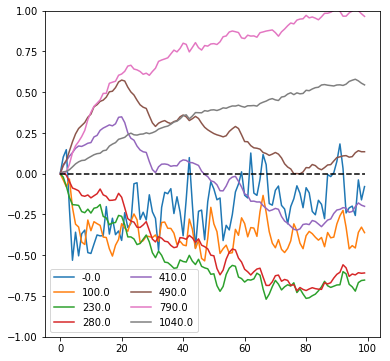

In [48]:
# time series
fig2=plt.figure(figsize=(6,6))

plt.plot(HOV[0,:], label=str(levels[0])) # 0
plt.plot(HOV[10,:], label=str(levels[10])) # 100


plt.plot(HOV[15,:], label=str(levels[15])) # 200

plt.plot(HOV[16,:], label=str(levels[16])) # 300

plt.plot(HOV[18,:], label=str(levels[18])) # 400

plt.plot(HOV[19,:], label=str(levels[19])) # 500

plt.plot(HOV[22,:], label=str(levels[22]))

plt.plot(HOV[24,:], label=str(levels[24]))

plt.ylim(-1.,1.)

plt.plot(np.zeros_like(HOV.mean(axis=0)), linestyle='dashed', color='k')
plt.legend(ncol=2)

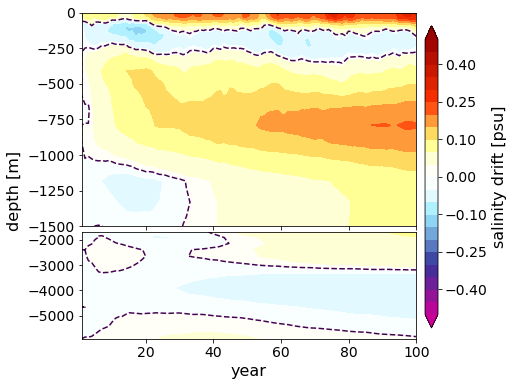

In [49]:
# plot Hovmoeller S diagram
fig3, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False, figsize=(6,6), gridspec_kw = {'height_ratios':[2, 1]})
emphasize=28 #25

#conlevels = np.arange(-0.5, 0.5+0.05, 0.05) # 
conlevels = np.array([-0.5,-0.45,-0.4,-0.35,-0.3,-0.25,-0.2,-0.15,-0.1,-0.05, -0.01,0.,0.01, 0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5])
TT,LL=np.meshgrid(np.arange(0,np.shape(hovmoeller_S)[0]), -levels)
HOV=(hovmoeller_S-hovmoeller_S[0,:]).T
#HOV=(hovmoeller_T-hovmoeller_T[0:10,:].mean(axis=0)).T # initial decade

# plot diagram
CS0 = ax1.contourf(1+TT[0:emphasize,:], LL[0:emphasize,:], HOV[0:emphasize,:], levels = conlevels, cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
# add contour of neutral change
ax1.contour(1+TT[0:emphasize,:], LL[0:emphasize,:], HOV[0:emphasize,:], levels = [0], color='k', linestyles='dashed'); # cm.seismic

# plot lower diagram
CS1 = ax2.contourf(1+TT[emphasize: ,:], LL[emphasize:, :], HOV[emphasize:, :], levels = conlevels, cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
# add contour of neutral change
ax2.contour(1+TT[emphasize: ,:], LL[emphasize:, :], HOV[emphasize:, :], levels = [0], color='k', linestyles='dashed');
fig3.subplots_adjust(hspace=0.035)

# change font sizes
plt.xlabel('year', fontsize=16)
plt.text(-21,1000, 'depth [m]', fontsize=16, rotation=90) # plt.ylabel('depth [m]', fontsize=16)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
ax1.tick_params(axis='y', labelsize=14)

# add colorbar

# Make an axis for the colorbar on the right side
cax = fig3.add_axes([0.92, 0.15, 0.03, 0.7]) #[*left*, *bottom*, *width*, *height*]
cbar=plt.colorbar(CS0, cax=cax)
cbar.set_label('salinity drift [psu]', fontsize=16)
cbar.ax.tick_params(labelsize=14) 

#plt.tight_layout()
#plt.close('all')

In [50]:
profiles['salinity']['HR']['initial']=HOV[:,0]
profiles['salinity']['HR']['last']=HOV[:,70:100].mean(axis=1)

In [51]:
saveFIG=True
if saveFIG==True:
   pp = PdfPages('/pf/a/a270046/hierarchy/figuresJuly2018/hovmoeller_'+meshname4plots+'.pdf')
   pp.savefig(fig,bbox_inches = 'tight')
   pp.close()

   pp = PdfPages('/pf/a/a270046/hierarchy/figuresJuly2018/hovmoeller_series_'+meshname4plots+'.pdf')
   pp.savefig(fig2,bbox_inches = 'tight')
   pp.close()
    
   pp = PdfPages('/pf/a/a270046/hierarchy/figuresJuly2018/hovmoeller_S_'+meshname4plots+'.pdf')
   pp.savefig(fig3,bbox_inches = 'tight')
   pp.close() 

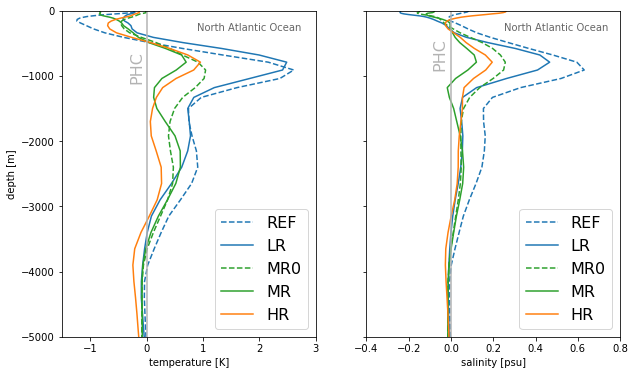

In [55]:
# plot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(10,6))

# temperature
ax1.plot(profiles['temperature']['REF']['last'],LL[:,0], color='C0', label='REF', linestyle='--')
ax1.plot(profiles['temperature']['LR']['last'],LL[:,0], color='C0', label='LR')
ax1.plot(profiles['temperature']['MR0']['last'],LL[:,0], color='C2', label='MR0', linestyle='--')
ax1.plot(profiles['temperature']['MR']['last'],LL[:,0], color='C2', label='MR')
ax1.plot(profiles['temperature']['HR']['last'],LL[:,0], color='C1', label='HR')
ax1.set_xlim([-1.5, 3.0])
ax1.set_ylim([-5000, 0])
ax1.legend(loc='lower right',fontsize=16)
ax1.set_xlabel('temperature [K]')
ax1.set_ylabel('depth [m]')

# salinity
ax2.plot(profiles['salinity']['REF']['last'],LL[:,0], color='C0', label='REF', linestyle='--')
ax2.plot(profiles['salinity']['LR']['last'],LL[:,0], color='C0', label='LR')
ax2.plot(profiles['salinity']['MR0']['last'],LL[:,0], color='C2', label='MR0', linestyle='--')
ax2.plot(profiles['salinity']['MR']['last'],LL[:,0], color='C2', label='MR')
ax2.plot(profiles['salinity']['HR']['last'],LL[:,0], color='C1', label='HR')
ax2.set_xlim([-0.4, 0.8])
ax2.set_ylim([-5000, 0])
ax2.legend(loc='lower right',fontsize=16)
ax2.set_xlabel('salinity [psu]')

# beautify
ax1.axvline(x=0., color='0.7', linestyle='-')
ax1.text(-.3,-800.,'PHC',color='0.7',fontsize=16, rotation='90')
ax2.axvline(x=0., color='0.7', linestyle='-')
ax2.text(-.09,-600.,'PHC',color='0.7',fontsize=16, rotation='90')
ax1.text(0.9,-300.,'North Atlantic Ocean',color='0.4',fontsize=10, rotation='0')
ax2.text(0.25,-300.,'North Atlantic Ocean',color='0.4',fontsize=10, rotation='0')

In [56]:
saveFIG=True
if saveFIG==True:
   pp = PdfPages('/pf/a/a270046/hierarchy/figuresJuly2018/profiles_NorthAtlantic.pdf')
   pp.savefig(fig,bbox_inches = 'tight')
   pp.close()